In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm

# load dataset
data = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/NO1_preprocessed.csv', parse_dates=['datetime'])

data=data.set_index('datetime')
data=pd.DataFrame(data['price'], index=data.index)

In [2]:
def prepare_data(data):
    steps = 24
    dataset_for_prediction = data.copy()
    dataset_for_prediction['target'] = dataset_for_prediction['price'].shift(-steps)
    dataset_for_prediction = dataset_for_prediction.dropna()

    train_set = dataset_for_prediction[:365*24*3] 
    test_set = dataset_for_prediction[365*24*3:] 

    
    # split the data into input (X) and output (y)
    train_X = train_set.drop('target', axis=1).values
    train_y = train_set['target'].values
    test_X = test_set.drop('target', axis=1).values
    test_y = test_set['target'].values

    # apply min-max scaling to the input and output data
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
    test_y = scaler_y.transform(test_y.reshape(-1, 1))

    return train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set

In [3]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y, train_set, test_set= prepare_data(data)

In [4]:
tscv = TimeSeriesSplit(n_splits=365, test_size=24)

In [5]:

val_preds=[]
rmse=[]
mape=[]
mae=[]
forecast=pd.Series()
for train_index, val_index in tqdm(tscv.split(train_X)):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    train_dmatrix = xgb.DMatrix(X_train, label=y_train)
    test_dmatrix = xgb.DMatrix(X_val, label=y_val)
    
        # set hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 3,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'lambda':0.2
    }

    # train model
    num_rounds = 100
    model = xgb.train(params, train_dmatrix, num_rounds)

    # predict on test set
    preds = model.predict(test_dmatrix)

    # invert scaling to get unscaled predictions
    preds = preds.reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    y_val = np.array(y_val).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])
    val_preds.append(preds)
    mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    mae.append(mean_absolute_error(y_val, preds))

/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43266/1618375769.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  forecast=pd.Series()
365it [06:43,  1.11s/it]


In [6]:
# compute the residuals
residuals = train_set['target'][365*24*2:].values - val_preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))
print("Mean MAE:", np.mean(mae))

Residual Sum of Squares (RSS):  1.656646581630411e+18
Mean RMSE: 40366.23515616467
Mean MAPE: 92.84203425912453
Mean MAE: 33055.512720339706


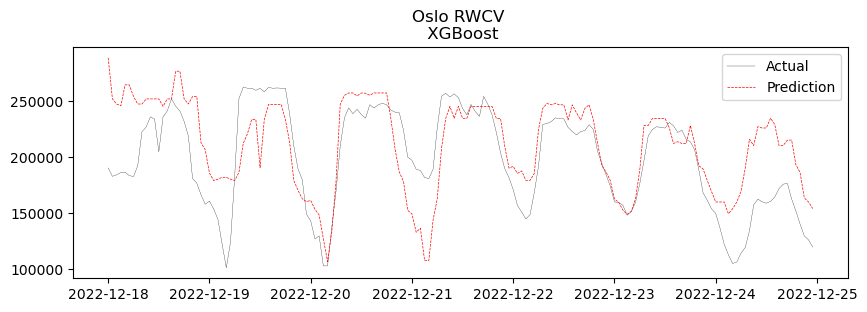

In [7]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)


train_set.index.freq = 'H'

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(train_set.index[-24*14:-24*7].shift(24), train_set['target'][-24*14:-24*7].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(train_set.index[-24*14:-24*7].shift(24), forecast[-24*14:-24*7], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Oslo RWCV \n XGBoost')
plt.legend()
plt.show()



In [8]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


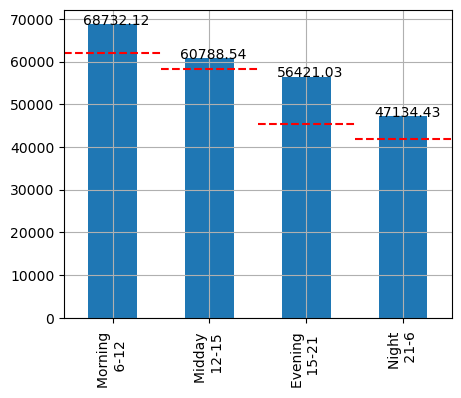

In [9]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=62023, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=58327, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=45331, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=41924, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))

plt.show()

In [10]:
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


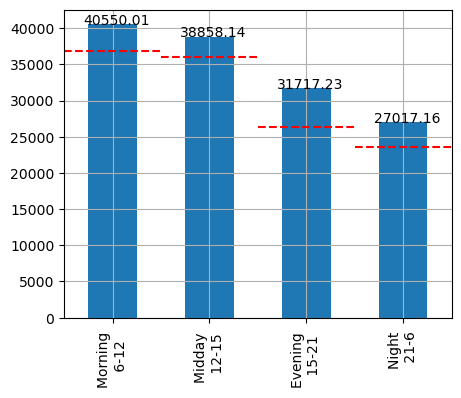

In [11]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=36809, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=36069, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=26361, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=23577, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))


plt.show()

RMSE: 29156.8621, MAPE: 26.2211% , MAE:  20268.9854, RSS:  1796309065828.5811


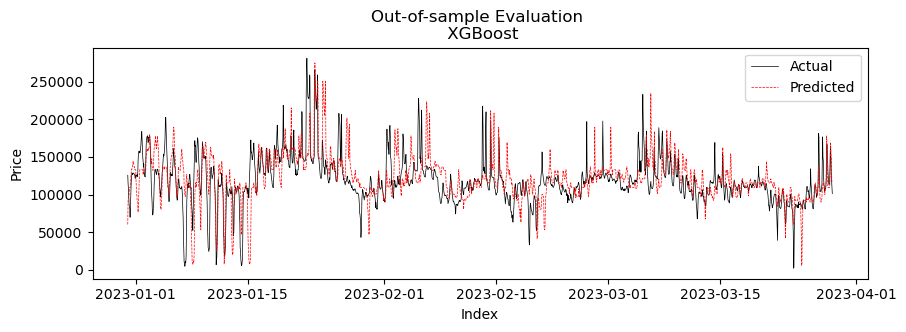

In [12]:

# prepare data
train_dmatrix = xgb.DMatrix(train_X, label=train_y)
test_dmatrix = xgb.DMatrix(test_X, label=test_y)

# set hyperparameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda':0.2
}

# train model
num_rounds = 100
model = xgb.train(params, train_dmatrix, num_rounds)

# predict on test set
preds = model.predict(test_dmatrix)

# invert scaling to get unscaled predictions
preds = preds.reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)

# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, linestyle='--', c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Out-of-sample Evaluation \n XGBoost')
plt.legend()
plt.show()


In [13]:

# load dataset
data = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/NO2_preprocessed.csv', parse_dates=['datetime'])

data=data.set_index('datetime')
data=pd.DataFrame(data['price'], index=data.index)

In [14]:
def prepare_data(data):
    steps = 24
    dataset_for_prediction = data.copy()
    dataset_for_prediction['target'] = dataset_for_prediction['price'].shift(-steps)
    dataset_for_prediction = dataset_for_prediction.dropna()

    train_set = dataset_for_prediction[:365*24*3] 
    test_set = dataset_for_prediction[365*24*3:] 

    
    # split the data into input (X) and output (y)
    train_X = train_set.drop('target', axis=1).values
    train_y = train_set['target'].values
    test_X = test_set.drop('target', axis=1).values
    test_y = test_set['target'].values

    # apply min-max scaling to the input and output data
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
    test_y = scaler_y.transform(test_y.reshape(-1, 1))

    return train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set

In [15]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y, train_set, test_set= prepare_data(data)

In [16]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm

In [17]:
tscv = TimeSeriesSplit(n_splits=365, test_size=24)

In [18]:

val_preds=[]
rmse=[]
mape=[]
forecast=pd.Series()
for train_index, val_index in tqdm(tscv.split(train_X)):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    train_dmatrix = xgb.DMatrix(X_train, label=y_train)
    test_dmatrix = xgb.DMatrix(X_val, label=y_val)
    
        # set hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 3,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'lambda':0.2
    }

    # train model
    num_rounds = 100
    model = xgb.train(params, train_dmatrix, num_rounds)

    # predict on test set
    preds = model.predict(test_dmatrix)

    # invert scaling to get unscaled predictions
    preds = preds.reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    y_val = np.array(y_val).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])
    val_preds.append(preds)
    mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    

/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43266/1031886835.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  forecast=pd.Series()
365it [06:28,  1.06s/it]


In [19]:
# compute the residuals
residuals = train_set['target'][365*24*2:].values - val_preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))
print("Mean MAE:", np.mean(mae))

Residual Sum of Squares (RSS):  2.1560538272933043e+18
Mean RMSE: 47145.9283408132
Mean MAPE: 96.31895877493974
Mean MAE: 20268.985396392865


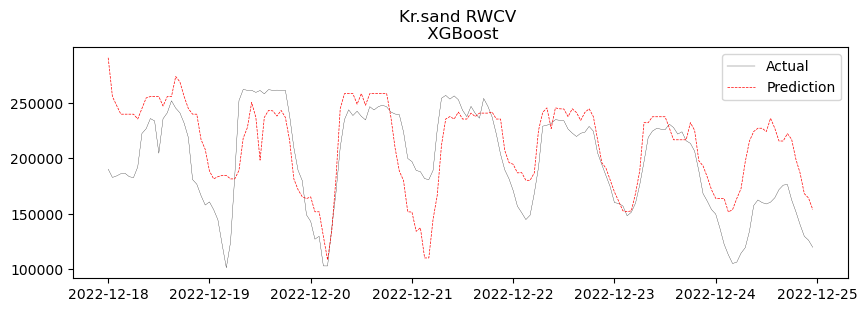

In [20]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)


train_set.index.freq = 'H'

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(train_set.index[-24*14:-24*7].shift(24), train_set['target'][-24*14:-24*7].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(train_set.index[-24*14:-24*7].shift(24), forecast[-24*14:-24*7], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Kr.sand RWCV \n XGBoost')
plt.legend()
plt.show()



In [21]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


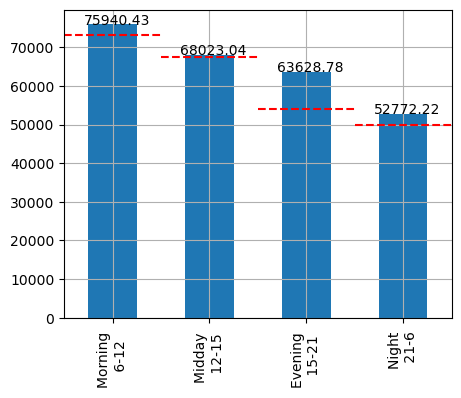

In [22]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=73173, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=67576, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=53986, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=49911, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    

plt.show()

In [23]:
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


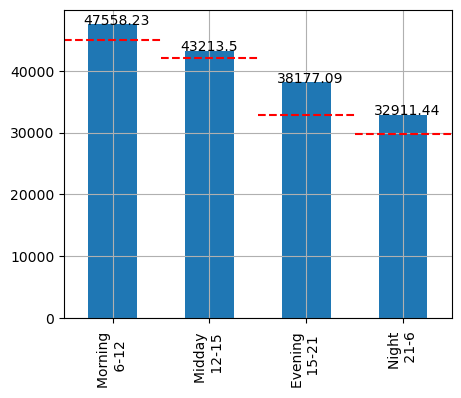

In [24]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=44972, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=42098, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=32833, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=29745, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))


plt.show()

Residual Sum of Squares (RSS):  1844480549008.5999
RMSE: 29545.2243, MAPE: 26.7766% , MAE:  20715.3578, RSS:  1844480549008.5999


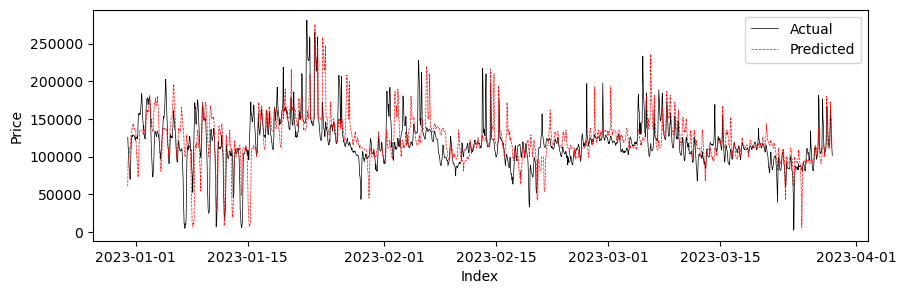

In [25]:

# prepare data
train_dmatrix = xgb.DMatrix(train_X, label=train_y)
test_dmatrix = xgb.DMatrix(test_X, label=test_y)

# set hyperparameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda':0.2
}

# train model
num_rounds = 100
model = xgb.train(params, train_dmatrix, num_rounds)

# predict on test set
preds = model.predict(test_dmatrix)

# invert scaling to get unscaled predictions
preds = preds.reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)

# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, linestyle='--', c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()


In [26]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm

In [27]:

# load dataset
data = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/NO3_preprocessed.csv', parse_dates=['datetime'])

data=data.set_index('datetime')
data=pd.DataFrame(data['price'], index=data.index)

In [28]:
def prepare_data(data):
    steps = 24
    dataset_for_prediction = data.copy()
    dataset_for_prediction['target'] = dataset_for_prediction['price'].shift(-steps)
    dataset_for_prediction = dataset_for_prediction.dropna()

    train_set = dataset_for_prediction[:365*24*3] 
    test_set = dataset_for_prediction[365*24*3:] 

    
    # split the data into input (X) and output (y)
    train_X = train_set.drop('target', axis=1).values
    train_y = train_set['target'].values
    test_X = test_set.drop('target', axis=1).values
    test_y = test_set['target'].values

    # apply min-max scaling to the input and output data
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
    test_y = scaler_y.transform(test_y.reshape(-1, 1))

    return train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set

In [29]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y, train_set, test_set= prepare_data(data)

In [30]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm

In [31]:
tscv = TimeSeriesSplit(n_splits=365, test_size=24)

In [32]:

val_preds=[]
rmse=[]
mape=[]
forecast=pd.Series()
for train_index, val_index in tqdm(tscv.split(train_X)):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    train_dmatrix = xgb.DMatrix(X_train, label=y_train)
    test_dmatrix = xgb.DMatrix(X_val, label=y_val)
    
        # set hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 3,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'lambda':0.2
    }

    # train model
    num_rounds = 100
    model = xgb.train(params, train_dmatrix, num_rounds)

    # predict on test set
    preds = model.predict(test_dmatrix)

    # invert scaling to get unscaled predictions
    preds = preds.reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    y_val = np.array(y_val).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])
    val_preds.append(preds)
    mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    

/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43266/1031886835.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  forecast=pd.Series()
280it [04:33,  1.08s/it]/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43266/1031886835.py:39: RuntimeWarning: divide by zero encountered in divide
  mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
314it [05:11,  1.12s/it]/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43266/1031886835.py:39: RuntimeWarning: divide by zero encountered in divide
  mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
315it [05:12,  1.10s/it]/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43266/1031886835.py:39: RuntimeWarning: divide by zero encountered in divide
  mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
365it [06:20,  1.04s/it]


In [33]:
# compute the residuals
residuals = train_set['target'][365*24*2:].values - val_preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))
print("Mean MAE:", np.mean(mae))

Residual Sum of Squares (RSS):  5.813859258750879e+17
Mean RMSE: 23386.561764495284
Mean MAPE: inf
Mean MAE: 20715.35775324997


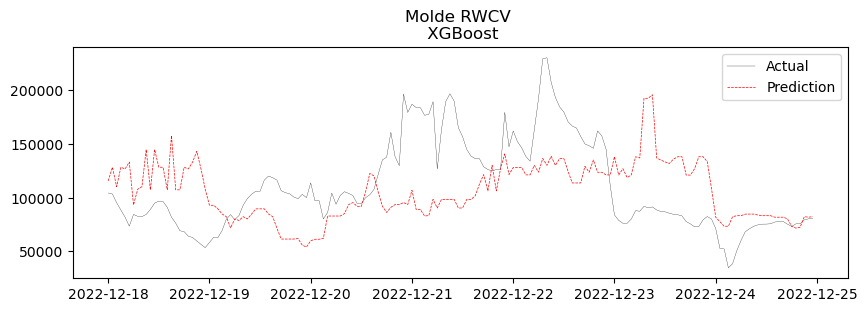

In [34]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)

train_set.index.freq = 'H'

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(train_set.index[-24*14:-24*7].shift(24), train_set['target'][-24*14:-24*7].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(train_set.index[-24*14:-24*7].shift(24), forecast[-24*14:-24*7], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Molde RWCV \n XGBoost')
plt.legend()
plt.show()



In [35]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


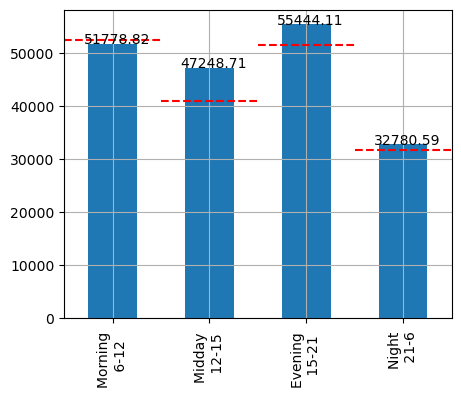

In [36]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=52421, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=40960, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=51591, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=31776, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    

plt.show()

In [37]:
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


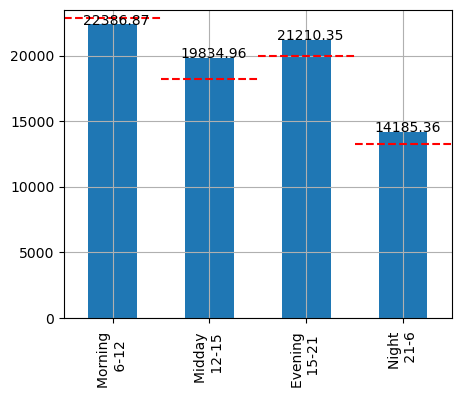

In [38]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=22891, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=18225, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=19937, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=13290, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))



plt.show()

Residual Sum of Squares (RSS):  1712565851459.0312
RMSE: 28469.1101, MAPE: 35.7987% , MAE:  19687.4557, RSS:  1712565851459.0312


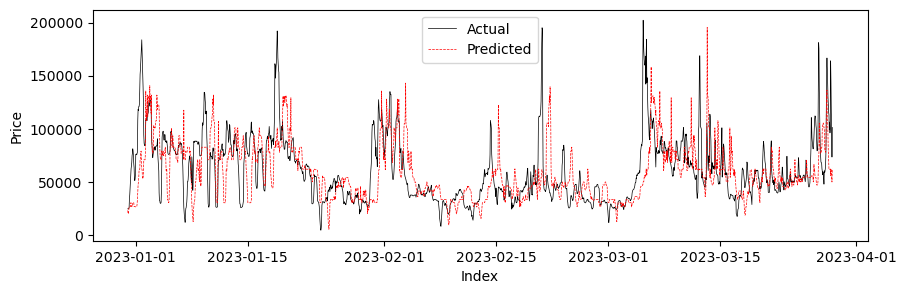

In [39]:

# prepare data
train_dmatrix = xgb.DMatrix(train_X, label=train_y)
test_dmatrix = xgb.DMatrix(test_X, label=test_y)

# set hyperparameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda':0.2
}

# train model
num_rounds = 100
model = xgb.train(params, train_dmatrix, num_rounds)

# predict on test set
preds = model.predict(test_dmatrix)

# invert scaling to get unscaled predictions
preds = preds.reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)

# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, linestyle='--', c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()


In [40]:

# load dataset
data = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/NO4_preprocessed.csv', parse_dates=['datetime'])

data=data.set_index('datetime')
data=pd.DataFrame(data['price'], index=data.index)

In [41]:
def prepare_data(data):
    steps = 24
    dataset_for_prediction = data.copy()
    dataset_for_prediction['target'] = dataset_for_prediction['price'].shift(-steps)
    dataset_for_prediction = dataset_for_prediction.dropna()

    train_set = dataset_for_prediction[:365*24*3] 
    test_set = dataset_for_prediction[365*24*3:] 

    
    # split the data into input (X) and output (y)
    train_X = train_set.drop('target', axis=1).values
    train_y = train_set['target'].values
    test_X = test_set.drop('target', axis=1).values
    test_y = test_set['target'].values

    # apply min-max scaling to the input and output data
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
    test_y = scaler_y.transform(test_y.reshape(-1, 1))

    return train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set

In [42]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y, train_set, test_set= prepare_data(data)

In [43]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm

In [44]:
tscv = TimeSeriesSplit(n_splits=365, test_size=24)

In [45]:

val_preds=[]
rmse=[]
mape=[]
forecast=pd.Series()
for train_index, val_index in tqdm(tscv.split(train_X)):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    train_dmatrix = xgb.DMatrix(X_train, label=y_train)
    test_dmatrix = xgb.DMatrix(X_val, label=y_val)
    
        # set hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 3,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'lambda':0.2
    }

    # train model
    num_rounds = 100
    model = xgb.train(params, train_dmatrix, num_rounds)

    # predict on test set
    preds = model.predict(test_dmatrix)

    # invert scaling to get unscaled predictions
    preds = preds.reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    y_val = np.array(y_val).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])
    val_preds.append(preds)
    mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    

/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43266/1031886835.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  forecast=pd.Series()
280it [04:49,  1.09s/it]/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43266/1031886835.py:39: RuntimeWarning: divide by zero encountered in divide
  mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
314it [05:28,  1.09s/it]/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43266/1031886835.py:39: RuntimeWarning: divide by zero encountered in divide
  mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
315it [05:29,  1.14s/it]/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43266/1031886835.py:39: RuntimeWarning: divide by zero encountered in divide
  mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
365it [06:25,  1.06s/it]


In [46]:
# compute the residuals
residuals = train_set['target'][365*24*2:].values - val_preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))
print("Mean MAE:", np.mean(mae))

Residual Sum of Squares (RSS):  2.2527298746945027e+17
Mean RMSE: 12333.20324528479
Mean MAPE: inf
Mean MAE: 19687.455684952525


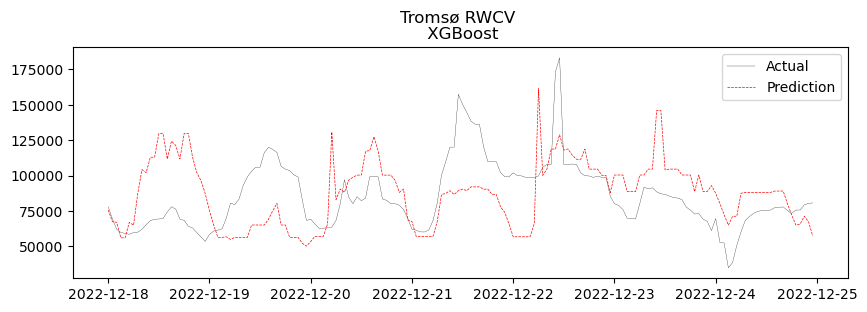

In [47]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)

train_set.index.freq = 'H'

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(train_set.index[-24*14:-24*7].shift(24), train_set['target'][-24*14:-24*7].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(train_set.index[-24*14:-24*7].shift(24), forecast[-24*14:-24*7], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Tromsø RWCV \n XGBoost')
plt.legend()
plt.show()



In [48]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


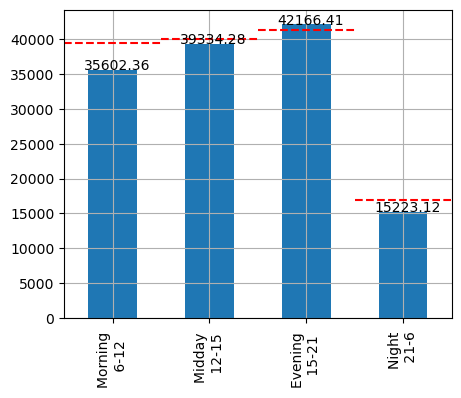

In [49]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=39456, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=40010, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=41405, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=16851, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    

plt.show()

In [50]:
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


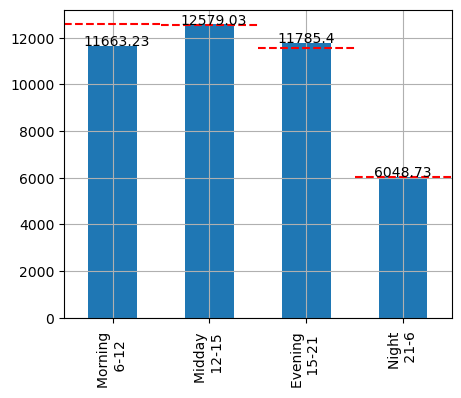

In [51]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=12597, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=12547, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=11571, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=6047, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))

plt.show()

Residual Sum of Squares (RSS):  896028667498.7983
RMSE: 20592.6010, MAPE: 25.4331% , MAE:  11424.1790, RSS:  896028667498.7983


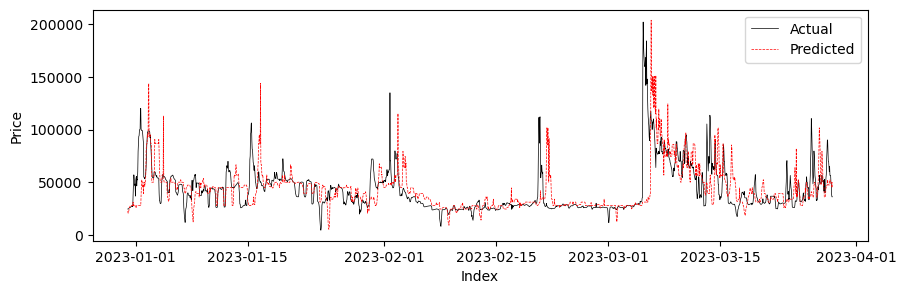

In [52]:

# prepare data
train_dmatrix = xgb.DMatrix(train_X, label=train_y)
test_dmatrix = xgb.DMatrix(test_X, label=test_y)

# set hyperparameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda':0.2
}

# train model
num_rounds = 100
model = xgb.train(params, train_dmatrix, num_rounds)

# predict on test set
preds = model.predict(test_dmatrix)

# invert scaling to get unscaled predictions
preds = preds.reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)

# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, linestyle='--', c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()


In [53]:

# load dataset
data = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/NO5_preprocessed.csv', parse_dates=['datetime'])

data=data.set_index('datetime')
data=pd.DataFrame(data['price'], index=data.index)

In [54]:
def prepare_data(data):
    steps = 24
    dataset_for_prediction = data.copy()
    dataset_for_prediction['target'] = dataset_for_prediction['price'].shift(-steps)
    dataset_for_prediction = dataset_for_prediction.dropna()

    train_set = dataset_for_prediction[:365*24*3] 
    test_set = dataset_for_prediction[365*24*3:] 

    
    # split the data into input (X) and output (y)
    train_X = train_set.drop('target', axis=1).values
    train_y = train_set['target'].values
    test_X = test_set.drop('target', axis=1).values
    test_y = test_set['target'].values

    # apply min-max scaling to the input and output data
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
    test_y = scaler_y.transform(test_y.reshape(-1, 1))

    return train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set

In [55]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y, train_set, test_set= prepare_data(data)

In [56]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm

In [57]:
tscv = TimeSeriesSplit(n_splits=365, test_size=24)

In [58]:

val_preds=[]
rmse=[]
mape=[]
forecast=pd.Series()
for train_index, val_index in tqdm(tscv.split(train_X)):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    train_dmatrix = xgb.DMatrix(X_train, label=y_train)
    test_dmatrix = xgb.DMatrix(X_val, label=y_val)
    
        # set hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 3,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'lambda':0.2
    }

    # train model
    num_rounds = 100
    model = xgb.train(params, train_dmatrix, num_rounds)

    # predict on test set
    preds = model.predict(test_dmatrix)

    # invert scaling to get unscaled predictions
    preds = preds.reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    y_val = np.array(y_val).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])
    val_preds.append(preds)
    mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    

/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43266/1031886835.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  forecast=pd.Series()
365it [06:22,  1.05s/it]


In [59]:
# compute the residuals
residuals = train_set['target'][365*24*2:].values - val_preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))
print("Mean MAE:", np.mean(mae))

Residual Sum of Squares (RSS):  1.6524838034330058e+18
Mean RMSE: 39208.42241824402
Mean MAPE: 86.50678260134899
Mean MAE: 11424.178994940177


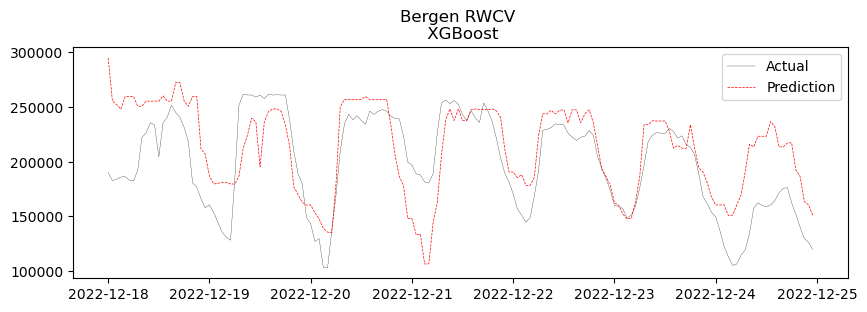

In [60]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)

train_set.index.freq = 'H'

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(train_set.index[-24*14:-24*7].shift(24), train_set['target'][-24*14:-24*7].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(train_set.index[-24*14:-24*7].shift(24), forecast[-24*14:-24*7], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Bergen RWCV \n XGBoost')
plt.legend()
plt.show()



In [61]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


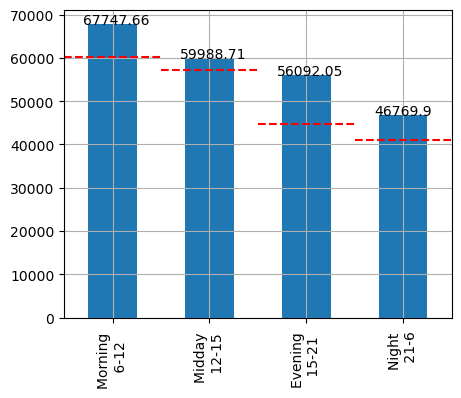

In [62]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
    
for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=60297, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=57312, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=44719, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=41079, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    

plt.show()

In [63]:
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


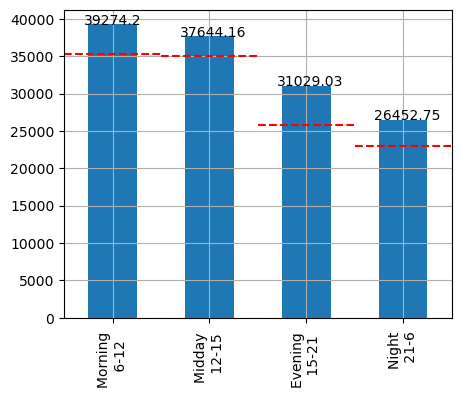

In [64]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=35282, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=35024, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=25820, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=23032, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))


plt.show()

Residual Sum of Squares (RSS):  1315359555022.379
RMSE: 24950.1117, MAPE: 16.2702% , MAE:  17137.9558, RSS:  1315359555022.3789


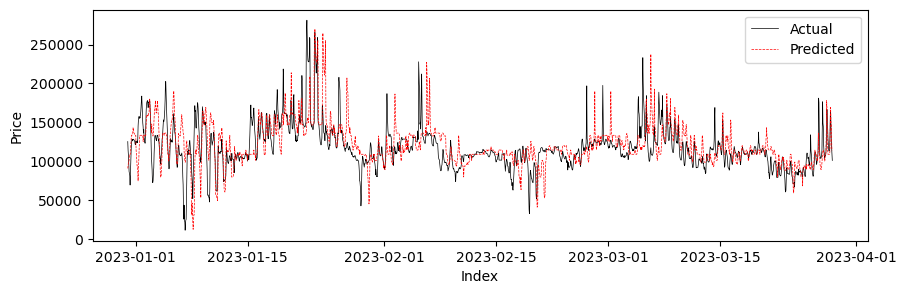

In [65]:

# prepare data
train_dmatrix = xgb.DMatrix(train_X, label=train_y)
test_dmatrix = xgb.DMatrix(test_X, label=test_y)

# set hyperparameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda':0.2
}

# train model
num_rounds = 100
model = xgb.train(params, train_dmatrix, num_rounds)

# predict on test set
preds = model.predict(test_dmatrix)

# invert scaling to get unscaled predictions
preds = preds.reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)

# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, linestyle='--', c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()


In [66]:

# load dataset
data = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/NO6_preprocessed.csv', parse_dates=['datetime'])

data=data.set_index('datetime')
data=pd.DataFrame(data['price'], index=data.index)

In [67]:
def prepare_data(data):
    steps = 24
    dataset_for_prediction = data.copy()
    dataset_for_prediction['target'] = dataset_for_prediction['price'].shift(-steps)
    dataset_for_prediction = dataset_for_prediction.dropna()

    train_set = dataset_for_prediction[:365*24*3] 
    test_set = dataset_for_prediction[365*24*3:] 

    
    # split the data into input (X) and output (y)
    train_X = train_set.drop('target', axis=1).values
    train_y = train_set['target'].values
    test_X = test_set.drop('target', axis=1).values
    test_y = test_set['target'].values

    # apply min-max scaling to the input and output data
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
    test_y = scaler_y.transform(test_y.reshape(-1, 1))

    return train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set

In [68]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y, train_set, test_set= prepare_data(data)

In [69]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm

In [70]:
tscv = TimeSeriesSplit(n_splits=365, test_size=24)

In [71]:

val_preds=[]
rmse=[]
mape=[]
forecast=pd.Series()
for train_index, val_index in tqdm(tscv.split(train_X)):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    train_dmatrix = xgb.DMatrix(X_train, label=y_train)
    test_dmatrix = xgb.DMatrix(X_val, label=y_val)
    
        # set hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 3,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'lambda':0.2
    }

    # train model
    num_rounds = 100
    model = xgb.train(params, train_dmatrix, num_rounds)

    # predict on test set
    preds = model.predict(test_dmatrix)

    # invert scaling to get unscaled predictions
    preds = preds.reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    y_val = np.array(y_val).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])
    val_preds.append(preds)
    mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    

/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43266/1031886835.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  forecast=pd.Series()
280it [04:08,  1.62it/s]/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43266/1031886835.py:39: RuntimeWarning: divide by zero encountered in divide
  mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
314it [04:27,  1.66it/s]/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43266/1031886835.py:39: RuntimeWarning: divide by zero encountered in divide
  mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
315it [04:28,  1.75it/s]/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43266/1031886835.py:39: RuntimeWarning: divide by zero encountered in divide
  mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
365it [05:06,  1.19it/s]


In [72]:
# compute the residuals
residuals = train_set['target'][365*24*2:].values - val_preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))
print("Mean MAE:", np.mean(mae))

Residual Sum of Squares (RSS):  5.813859258750879e+17
Mean RMSE: 23386.561764495284
Mean MAPE: inf
Mean MAE: 17137.955803729885


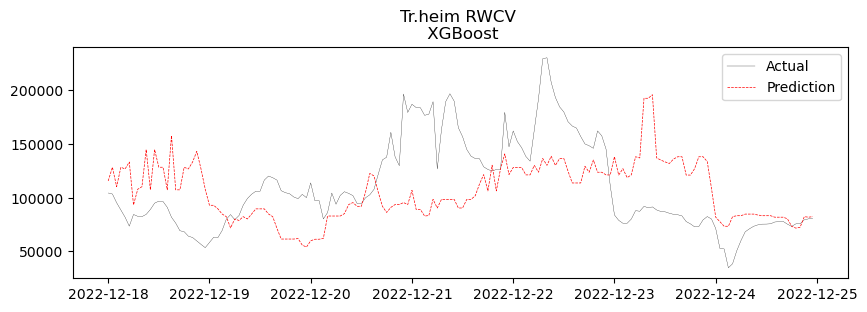

In [73]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)


train_set.index.freq = 'H'

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(train_set.index[-24*14:-24*7].shift(24), train_set['target'][-24*14:-24*7].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(train_set.index[-24*14:-24*7].shift(24), forecast[-24*14:-24*7], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Tr.heim RWCV \n XGBoost')
plt.legend()
plt.show()



In [74]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


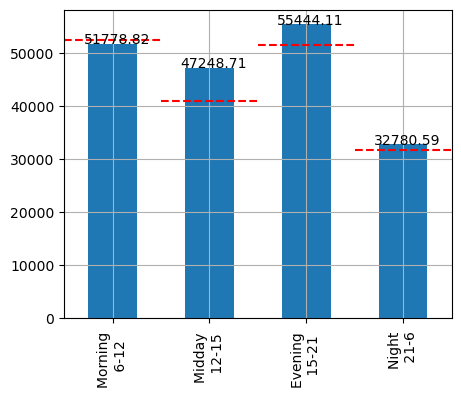

In [75]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=52421, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=40960, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=51591, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=31766, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    
    

plt.show()

In [76]:
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


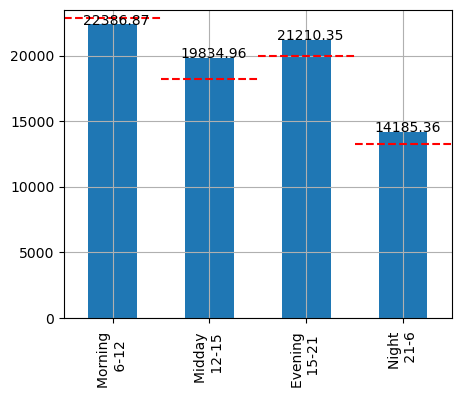

In [77]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    

for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=22891, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=18225, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=19937, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=13290, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))


plt.show()

Residual Sum of Squares (RSS):  1712565851459.0312
RMSE: 28469.1101, MAPE: 35.7987% , MAE:  19687.4557, RSS:  1712565851459.0312


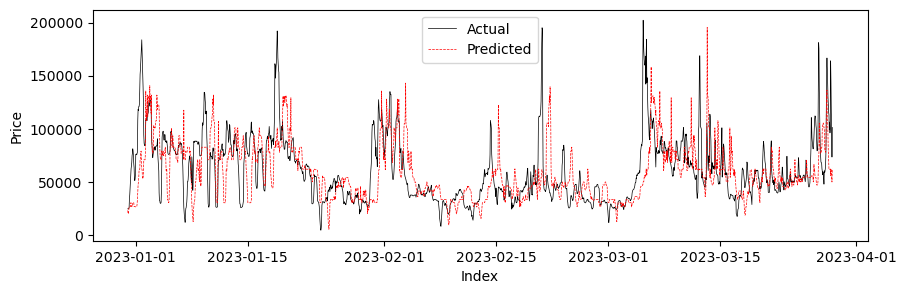

In [78]:

# prepare data
train_dmatrix = xgb.DMatrix(train_X, label=train_y)
test_dmatrix = xgb.DMatrix(test_X, label=test_y)

# set hyperparameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda':0.2
}

# train model
num_rounds = 100
model = xgb.train(params, train_dmatrix, num_rounds)

# predict on test set
preds = model.predict(test_dmatrix)

# invert scaling to get unscaled predictions
preds = preds.reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)

# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, linestyle='--', c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()
